# 다중 언어 다루기

## 데이터셋 로드

In [1]:
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


0      1   2  3         4          5   6       7   8           9
Tokens   Jeff   Dean  is  a  computer  scientist  at  Google  in  California
Tags    B-PER  I-PER   O  O         O          O   O   B-ORG   O       B-LOC

In [2]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME 서브셋 개수: {len(xtreme_subsets)}")

XTREME 서브셋 개수: 183


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [4]:
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [5]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환합니다.
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치를 로드합니다.
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # 각 분할을 언어 비율에 따라 다운샘플링하고 섞습니다.
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

de    fr    it    en
Number of training examples  12580  4580  1680  1180

In [7]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [11]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

0           1   2    3         4      5   6    7           8   \
Tokens  2.000  Einwohnern  an  der  Danziger  Bucht  in  der  polnischen   
Tags        O           O   O    O     B-LOC  I-LOC   O    O       B-LOC   

                  9        10 11  
Tokens  Woiwodschaft  Pommern  .  
Tags           B-LOC    I-LOC  O

In [12]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

LOC   ORG   PER
train       6186  5366  5810
validation  3172  2683  2893
test        3180  2573  3071

## 다중 언어 트랜스포머

## XLM-R 토큰화

In [13]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [14]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [15]:
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df

0      1      2       3      4    5     6      7      8     9
BERT   [CLS]   Jack    Spa  ##rrow  loves  New  York      !  [SEP]  None
XLM-R    <s>  ▁Jack  ▁Spar     row  ▁love    s  ▁New  ▁York      !  </s>

### 토큰화 파이프라인

![The steps in the tokenization pipeline](./images/chapter04_tokenizer-pipeline.png)

### SentencePiece 토크나이저

In [16]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

## 개체명 인식을 위한 트랜스포머

![Fine-tuning an encoder-based transformer for sequence classification](./images/chapter04_clf-architecture.png)

![Fine-tuning an encoder-based transformer for named entity recognition](./images/chapter04_ner-architecture.png)

## 트랜스포머 모델 클래스

### 바디와 헤드

![The `BertModel` class only contains the body of the model, while the BertFor<Task> classes combine the body with a dedicated head for a given task](./images/chapter04_bert-body-head.png)

### 토큰 분류를 위한 사용자 정의 모델 만들기

In [17]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # 모델 바디를 로드합니다.
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # 토큰 분류 헤드를 준비합니다.
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치를 로드하고 초기화합니다.
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻습니다.
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # 인코더 표현을 헤드에 통과시킵니다.
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # 손실을 계산합니다.
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # 모델 출력 객체를 반환합니다.
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)

### 사용자 정의 모델 로드하기

In [18]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [19]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_ids', 'classifier.bias', '

In [21]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

0      1      2      3      4  5     6      7   8     9
Tokens     <s>  ▁Jack  ▁Spar    row  ▁love  s  ▁New  ▁York   !  </s>
Input IDs    0  21763  37456  15555   5161  7  2356   5753  38     2

In [22]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"시퀀스에 있는 토큰 개수: {len(xlmr_tokens)}")
print(f"출력 크기: {outputs.shape}")

시퀀스에 있는 토큰 개수: 10
출력 크기: torch.Size([1, 10, 7])


In [23]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

0      1      2      3      4      5      6      7      8      9
Tokens    <s>  ▁Jack  ▁Spar    row  ▁love      s   ▁New  ▁York      !   </s>
Tags    B-ORG  B-ORG  B-ORG  I-LOC  I-LOC  I-LOC  B-ORG  I-LOC  B-ORG  B-ORG

In [24]:
def tag_text(text, tags, model, tokenizer):
    # 토큰을 준비합니다.
    tokens = tokenizer(text).tokens()
    # 시퀀스를 ID로 인코딩합니다.
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # 가능한 일곱 개의 클래스에 대한 분포를 예측합니다.
    outputs = model(input_ids)[0]
    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구합니다.
    predictions = torch.argmax(outputs, dim=2)
    # 데이터프레임으로 변환합니다.
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## NER 작업을 위해 텍스트 토큰화하기

In [25]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [26]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [27]:
pd.DataFrame([tokens], index=["Tokens"])

0       1           2  3    4     5     6   7    8      9   ...   15  \
Tokens  <s>  ▁2.000  ▁Einwohner  n  ▁an  ▁der  ▁Dan  zi  ger  ▁Buch  ...  ▁Wo   

       16   17      18   19    20 21 22 23    24  
Tokens  i  wod  schaft  ▁Po  mmer  n  ▁  .  </s>  

[1 rows x 25 columns]

In [28]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

0       1           2  3    4     5     6   7    8      9   ...  \
Tokens     <s>  ▁2.000  ▁Einwohner  n  ▁an  ▁der  ▁Dan  zi  ger  ▁Buch  ...   
Word IDs  None       0           1  1    2     3     4   4    4      5  ...   

           15 16   17      18   19    20  21  22  23    24  
Tokens    ▁Wo  i  wod  schaft  ▁Po  mmer   n   ▁   .  </s>  
Word IDs    9  9    9       9   10    10  10  11  11  None  

[2 rows x 25 columns]

In [29]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

0       1           2     3    4     5      6     7     8   \
Tokens      <s>  ▁2.000  ▁Einwohner     n  ▁an  ▁der   ▁Dan    zi   ger   
Word IDs   None       0           1     1    2     3      4     4     4   
Label IDs  -100       0           0  -100    0     0      5  -100  -100   
Labels      IGN       O           O   IGN    O     O  B-LOC   IGN   IGN   

              9   ...     15    16    17      18     19    20    21  22    23  \
Tokens     ▁Buch  ...    ▁Wo     i   wod  schaft    ▁Po  mmer     n   ▁     .   
Word IDs       5  ...      9     9     9       9     10    10    10  11    11   
Label IDs      6  ...      5  -100  -100    -100      6  -100  -100   0  -100   
Labels     I-LOC  ...  B-LOC   IGN   IGN     IGN  I-LOC   IGN   IGN   O   IGN   

             24  
Tokens     </s>  
Word IDs   None  
Label IDs  -100  
Labels      IGN  

[4 rows x 25 columns]

In [30]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [32]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [33]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [34]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

## 성능 측정

In [35]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [36]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # 레이블 IDs = -100 무시
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## XLM-RoBERTa 미세 튜닝하기

In [37]:
from transformers import TrainingArguments

num_epochs = 3
# 코랩에서 GPU 메모리 부족 에러가 나는 경우 batch_size를 16으로 줄여 주세요.
batch_size = 24  # 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps, push_to_hub=True)

In [38]:
from huggingface_hub import notebook_login

notebook_login()

In [39]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [40]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [41]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [42]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [44]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.5k/1.03G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Download file runs/Aug08_16-27-49_yocto-ci/events.out.tfevents.1691481125.yocto-ci.53380.1: 100%|##########| 4…

Download file runs/Aug08_16-27-49_yocto-ci/events.out.tfevents.1691480352.yocto-ci.53380.0: 100%|##########| 6…

Download file runs/Aug01_10-54-32_yocto-ci/events.out.tfevents.1690854939.yocto-ci.3608827.0: 100%|##########|…

Download file runs/Aug08_17-25-09_yocto-ci/events.out.tfevents.1691483116.yocto-ci.62671.0: 100%|##########| 6…

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file runs/Aug08_16-27-49_yocto-ci/events.out.tfevents.1691481125.yocto-ci.53380.1:  23%|##3       | 1.00…

Clean file runs/Aug08_16-27-49_yocto-ci/events.out.tfevents.1691480352.yocto-ci.53380.0:  17%|#6        | 1.00…

Download file sentencepiece.bpe.model:   0%|          | 3.40k/4.83M [00:00<?, ?B/s]

Clean file runs/Aug01_10-54-32_yocto-ci/events.out.tfevents.1690854939.yocto-ci.3608827.0:  17%|#6        | 1.…

Download file tokenizer.json:   0%|          | 8.19k/16.3M [00:00<?, ?B/s]

Clean file runs/Aug08_17-25-09_yocto-ci/events.out.tfevents.1691483116.yocto-ci.62671.0:  17%|#6        | 1.00…

Clean file sentencepiece.bpe.model:   0%|          | 1.00k/4.83M [00:00<?, ?B/s]

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [45]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file runs/Aug10_08-41-54_104-171-203-102/events.out.tfevents.1691657304.104-171-203-102.123934.0:   0%|…

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de
   bd2853a..4a8c46a  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de
   4a8c46a..1d42d7f  main -> main



'https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de/commit/4a8c46a470bbb5022962ecb9955bdf38c6b12ddd'

In [46]:
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

Epoch  Training Loss  Validation Loss        F1
0      1         0.2547         0.156529  0.830254
2      2         0.1278         0.140089  0.847820
4      3         0.0810         0.136394  0.860473

In [47]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

0      1      2      3     4     5           6    7     8        9   \
Tokens  <s>  ▁Jeff    ▁De     an  ▁ist  ▁ein  ▁Informati  ker  ▁bei  ▁Google   
Tags      O  B-PER  I-PER  I-PER     O     O           O    O     O    B-ORG   

         10          11     12    13  
Tokens  ▁in  ▁Kaliforni     en  </s>  
Tags      O       B-LOC  I-LOC     O

## 오류 분석

In [48]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 리스트의 딕셔너리를 데이터 콜레이터에 적합한 딕셔너리의 리스트로 변환합니다.
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # 입력과 레이블을 패딩하고 모든 텐서를 장치에 배치합니다.
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # 데이터를 모델에 전달합니다.
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # 마지막 축을 따라 가장 큰 로짓 값을 가진 클래스를 선택합니다.
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # 배치 차원을 펼친 다음 토큰마다 손실을 계산합니다.
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # 배치 차원을 다시 만들고 넘파이 배열로 변환합니다.
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [49]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7eff30a6ea60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [50]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

input_ids         attention_mask  \
0  [0, 10699, 11, 15, 16104, 1388, 2]  [1, 1, 1, 1, 1, 1, 1]   

                                        labels  \
0  [IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]   

                                                loss  \
0  [0.0, 0.024176193, 0.0, 0.026248658, 0.0208157...   

                                     predicted_label  \
0  [I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]   

                                 input_tokens  
0  [<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]

In [51]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

input_ids attention_mask labels  loss predicted_label  input_tokens
0     10699              1  B-ORG  0.02           B-ORG          ▁Ham
0        15              1  I-ORG  0.03           I-ORG            ▁(
0     16104              1  I-ORG  0.02           I-ORG  ▁Unternehmen
0      1388              1  I-ORG  0.02           I-ORG            ▁)
1     56530              1      O  0.00               O           ▁WE
1     83982              1  B-ORG  0.84           B-ORG          ▁Luz
1        10              1  I-ORG  1.28           I-LOC            ▁a

In [52]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # 멀티 컬럼을 삭제합니다.
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

0       1      2       3     4      5      6      7      8  \
input_tokens       ▁     ▁in   ▁der    ▁von    ▁/   ▁und     ▁(    ▁''     ▁)   
count           6066     989   1388     808   163   1171    246   2898    246   
mean            0.03    0.15   0.08    0.14  0.52   0.07   0.29   0.02   0.27   
sum           208.31  146.83  117.5  114.29  84.7  84.08  71.96  69.42  66.57   

                  9  
input_tokens     ▁A  
count           125  
mean           0.47  
sum           58.74

In [53]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

0       1        2       3       4       5        6
labels    B-ORG   I-LOC    I-ORG   B-LOC   B-PER   I-PER        O
count      2683    1462     3820    3172    2893    4139    43648
mean       0.62    0.58     0.49    0.33    0.28    0.18     0.03
sum     1665.01  854.53  1884.43  1060.3  816.14  756.85  1346.95

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title("Normalized confusion matrix")
    plt.show()

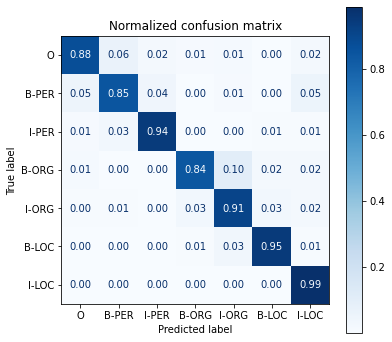

In [57]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [58]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

0     1     2      3      4      5         6     7      8      9   \
tokens    ▁''     8     .  ▁Juli    ▁''     ▁:  ▁Protest  camp   ▁auf   ▁dem   
labels  B-ORG   IGN   IGN  I-ORG  I-ORG  I-ORG     I-ORG   IGN  I-ORG  I-ORG   
preds       O     O     O      O      O      O         O     O      O      O   
losses   8.60  0.00  0.00   6.95   9.16   9.51      6.64  0.00   8.47   9.05   

              10     11          12     13      14     15     16    17  
tokens  ▁Gelände   ▁der  ▁Republika      n  ischen   ▁Gar     de  </s>  
labels     I-ORG  I-ORG       I-ORG    IGN     IGN  I-ORG    IGN   IGN  
preds          O      O       B-ORG  I-ORG   I-ORG  I-ORG  I-ORG     O  
losses      8.19   6.62        4.96   0.00    0.00   0.01   0.00  0.00

0     1      2      3     4     5      6      7      8      9   \
tokens    ▁'   ▁''     ▁Τ      Κ   ▁''    ▁'     ▁'    ▁''     ▁T    ▁''   
labels     O     O      O    IGN     O     O  B-LOC  I-LOC  I-LOC  I-LOC   
preds      O     O  B-ORG  I-ORG     O     O      O      O  B-ORG      O   
losses  0.00  0.00   6.01   0.00  0.00  0.00  10.11   9.65   8.70   6.32   

           10    11     12     13    14     15     16    17    18  
tokens     ▁'    ri    ▁''     ▁'     k    ▁''     ▁'   ala  </s>  
labels  I-LOC   IGN  I-LOC  I-LOC   IGN  I-LOC  I-LOC   IGN   IGN  
preds       O     O      O      O     O      O      O     O     O  
losses   6.65  0.00   6.68   7.13  0.00   7.98   8.37  0.00  0.00

0         1       2            3         4      5        6   \
tokens  ▁United  ▁Nations  ▁Multi  dimensional  ▁Integra    ted  ▁Stabil   
labels    B-PER     I-PER   I-PER          IGN     I-PER    IGN    I-PER   
preds     B-ORG     I-ORG   I-ORG        I-ORG     I-ORG  I-ORG    I-ORG   
losses     6.75      5.25    5.55         0.00      5.41   0.00     5.22   

             7         8      9      10        11        12         13     14  
tokens  ization  ▁Mission    ▁in   ▁the  ▁Central  ▁African  ▁Republic   </s>  
labels      IGN     I-PER  I-PER  I-PER     I-PER     I-PER      I-PER    IGN  
preds     I-ORG     I-ORG  I-ORG  I-ORG     I-ORG     I-ORG      I-ORG  I-ORG  
losses     0.00      5.12   6.05   6.15      5.65      5.39       5.33   0.00

In [59]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

0      1      2             3      4      5
tokens   ▁Ham      a     ▁(  ▁Unternehmen     ▁)   </s>
labels  B-ORG    IGN  I-ORG         I-ORG  I-ORG    IGN
preds   B-ORG  I-ORG  I-ORG         I-ORG  I-ORG  I-ORG
losses   0.02   0.00   0.03          0.02   0.02   0.00

0      1      2      3      4      5      6      7
tokens  ▁Kesk    kül      a     ▁(  ▁Mart     na     ▁)   </s>
labels  B-LOC    IGN    IGN  I-LOC  I-LOC    IGN  I-LOC    IGN
preds   B-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC  I-LOC
losses   0.03   0.00   0.00   0.02   0.02   0.00   0.02   0.00

## 교차 언어 전이

In [60]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [61]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"[de] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['de']:.3f}")

[de] 데이터셋에서 [de] 모델의 F1-점수: 0.870


In [62]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

0      1      2      3     4            5    6      7        8    9   \
Tokens  <s>  ▁Jeff    ▁De     an  ▁est  ▁informatic  ien  ▁chez  ▁Google  ▁en   
Tags      O  B-PER  I-PER  I-PER     O            O    O      O    B-ORG    O   

           10     11     12    13  
Tokens  ▁Cali    for    nie  </s>  
Tags    B-LOC  I-LOC  I-LOC     O

In [63]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [64]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"[fr] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

[fr] 데이터셋에서 [de] 모델의 F1-점수: 0.704


In [65]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"[it] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

[it] 데이터셋에서 [de] 모델의 F1-점수: 0.683


In [66]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"[en] 데이터셋에서 [de] 모델의 F1-점수: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

[en] 데이터셋에서 [de] 모델의 F1-점수: 0.597


### 제로 샷 전이가 유용할 때

In [67]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size
    
    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")
    
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [68]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [69]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


num_samples  f1_score
0          250  0.169571

In [70]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<ipython-input-70-95404e7c65ac>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(


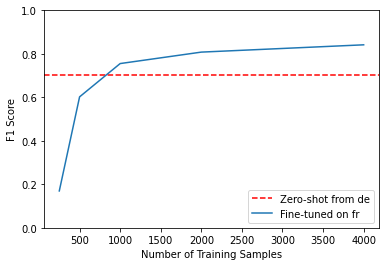

In [71]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### 다국어에서 동시에 미세 튜닝하기

In [72]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [73]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [74]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de-fr
   22b41be..e7b08f8  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de-fr
   e7b08f8..c2bd673  main -> main



'https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-de-fr/commit/e7b08f881b4ba8c848822e591692952f509e544e'

In [75]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"[{lang}] 데이터셋에서 [de-fr] 모델의 F1-점수: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

[de] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.866


[fr] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.857


[it] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.787


[en] 데이터셋에서 [de-fr] 모델의 F1-점수: 0.673


In [76]:
corpora = [panx_de_encoded]

# 반복에서 독일어는 제외합니다.
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # 단일 언어 말뭉치에서 미세 튜닝합니다.
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # 딕셔너리에 F1-점수를 모읍니다.
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # 단일 언어 말뭉치를 corpora 리스트에 추가합니다.
    corpora.append(ds_encoded)

Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-fr into local empty directory.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-fr
   34e2167..d6a4fbc  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-fr
   d6a4fbc..9b08cb9  main -> main



Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-it into local empty directory.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-it
   d84eb31..00fe9b9  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-it
   00fe9b9..28fb011  main -> main



Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-en into local empty directory.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-en
   ff5526a..0354e76  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-en
   0354e76..363695a  main -> main



In [77]:
corpora_encoded = concatenate_splits(corpora)

In [78]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

Cloning https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-all into local empty directory.
/home/ubuntu/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 1.00/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 1.00/16.3M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 1.00/4.83M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-all
   07fb830..f72ddd4  main -> main

To https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-all
   f72ddd4..8d250f7  main -> main



'https://huggingface.co/yezune/xlm-roberta-base-finetuned-panx-all/commit/f72ddd4db5500776ed8be2f76f1352d4133e06f8'

In [79]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [80]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on      de      fr      it      en
Fine-tune on                                
de            0.8702  0.7036  0.6833  0.5970
each          0.8702  0.8321  0.8244  0.7038
all           0.8670  0.8687  0.8715  0.7681

## 모델 위젯 사용하기

![A Hub widget" caption="Example of a widget on the Hugging Face Hub](./images/chapter04_ner-widget.png)

## 결론